# Custom lightkurve extraction

Let's extract the lightcurve from the Sector 10 TPF so we know we can do it for Sector 36.

In [1]:
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import lightkurve as lk

In [3]:
from astropy.coordinates import SkyCoord

In [4]:
sr = lk.search_tesscut('Luhman 16')
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 10,2019,TESScut,1426,Luhman 16,0.0


In [5]:
tpf = sr.download(cutout_size=(16, 51))

Coordinates from Apai et al. 2021

In [6]:
c_TESS = SkyCoord(ra=162.303282427*u.degree, 
             dec=-53.317573814*u.degree, 
             distance=1.0/0.50114 * u.pc, 
             pm_ra_cosdec=-2763*u.mas/u.yr,
             pm_dec=+358*u.mas/u.yr, 
             radial_velocity=20.0*u.km/u.s,
             frame='icrs',
             obstime=Time('2019.26', format='decimalyear')
            )

In [7]:
x0_cutout, y0_cutout = tpf.wcs.world_to_pixel(c_TESS)
x0, y0 = tpf.column+x0_cutout, tpf.row+y0_cutout

In [8]:
ny, nx = tpf.flux[0].shape

In [9]:
xvec, yvec = np.arange(tpf.column, tpf.column+nx), np.arange(tpf.row, tpf.row+ny)

In [10]:
xx, yy = np.meshgrid(xvec, yvec)

In [11]:
radius_threshold = 1.1

In [12]:
pixel_distance = np.sqrt((xx-x0)**2 + (yy-y0)**2)

In [13]:
aperture_mask = pixel_distance < radius_threshold

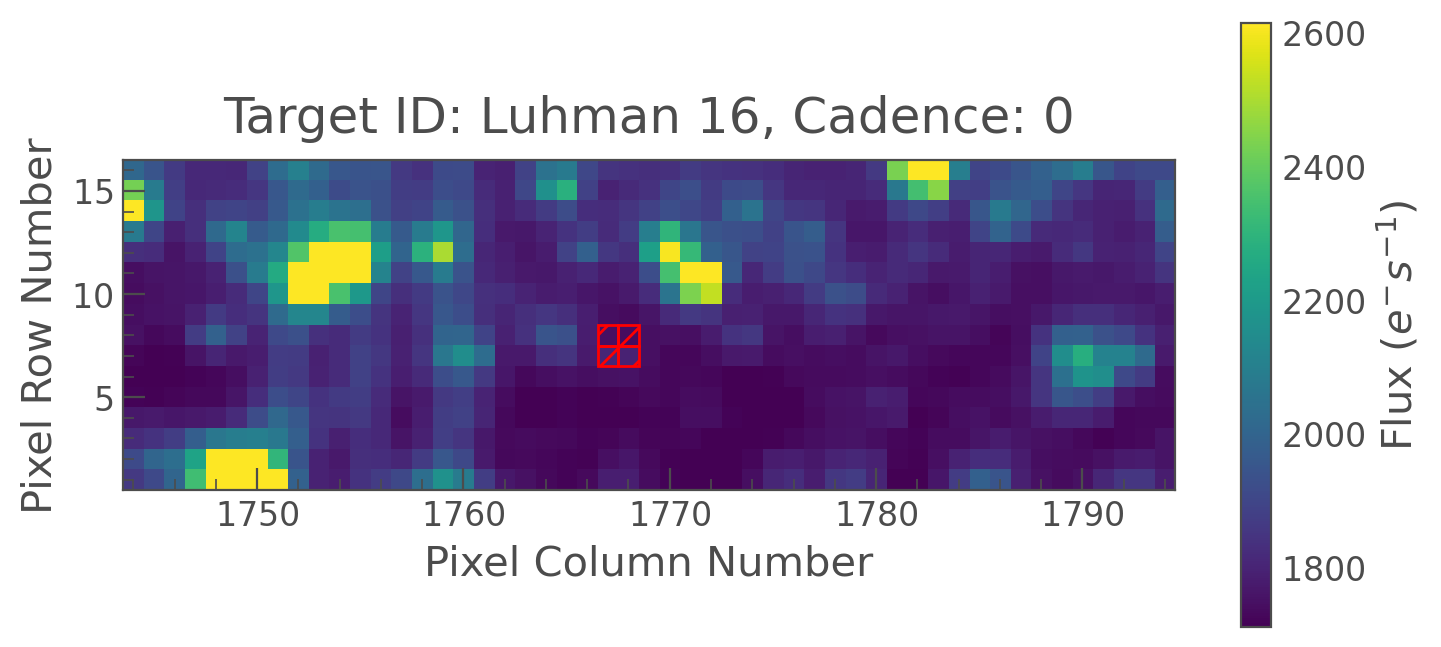

In [14]:
tpf.plot(aperture_mask=aperture_mask);

In [15]:
def background_subtract_lightcurve(tpf, aperture_mask):
    '''background subtract a lightcurve'''
    median_image = np.nanmedian(tpf.flux.value,axis=0)
    lo = np.percentile(median_image, 15)
    bkg_pixel_mask = (median_image < lo) & ~aperture_mask
    
    n_bkg_pixels = bkg_pixel_mask.sum()
    n_tar_pixels = aperture_mask.sum()
    
    bkg_lc = tpf.to_lightcurve(aperture_mask=bkg_pixel_mask)
    tar_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
    net_lc = tar_lc - (bkg_lc / n_bkg_pixels * n_tar_pixels)
    
    return net_lc

In [16]:
corrected_lc = background_subtract_lightcurve(tpf, aperture_mask).remove_outliers(sigma=3).normalize()

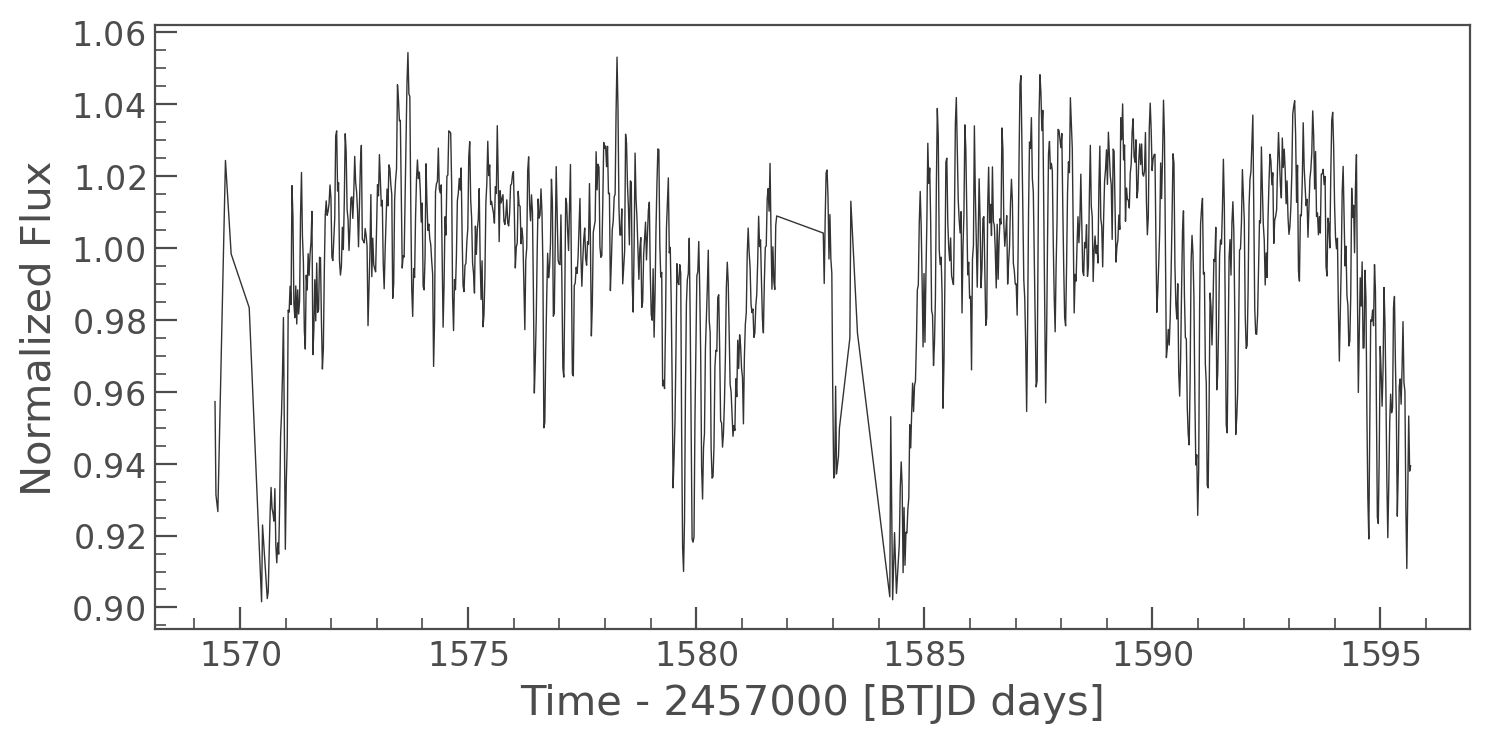

In [17]:
corrected_lc.plot();

Woohoo!  Looks similar to Apai et al. 2021.  Let's compare it head-to-head.

In [18]:
import glob

In [19]:
fns = glob.glob('../data/TESS/**/*.fits', recursive=True)
fn = fns[0]

In [20]:
lc_pathos = lk.LightCurve.read(fn, format='pathos').remove_outliers(sigma=3).normalize()

/home/gully/miniconda3/envs/varsity/lib/python3.7/site-packages/lightkurve/lightcurve.py:970: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning,


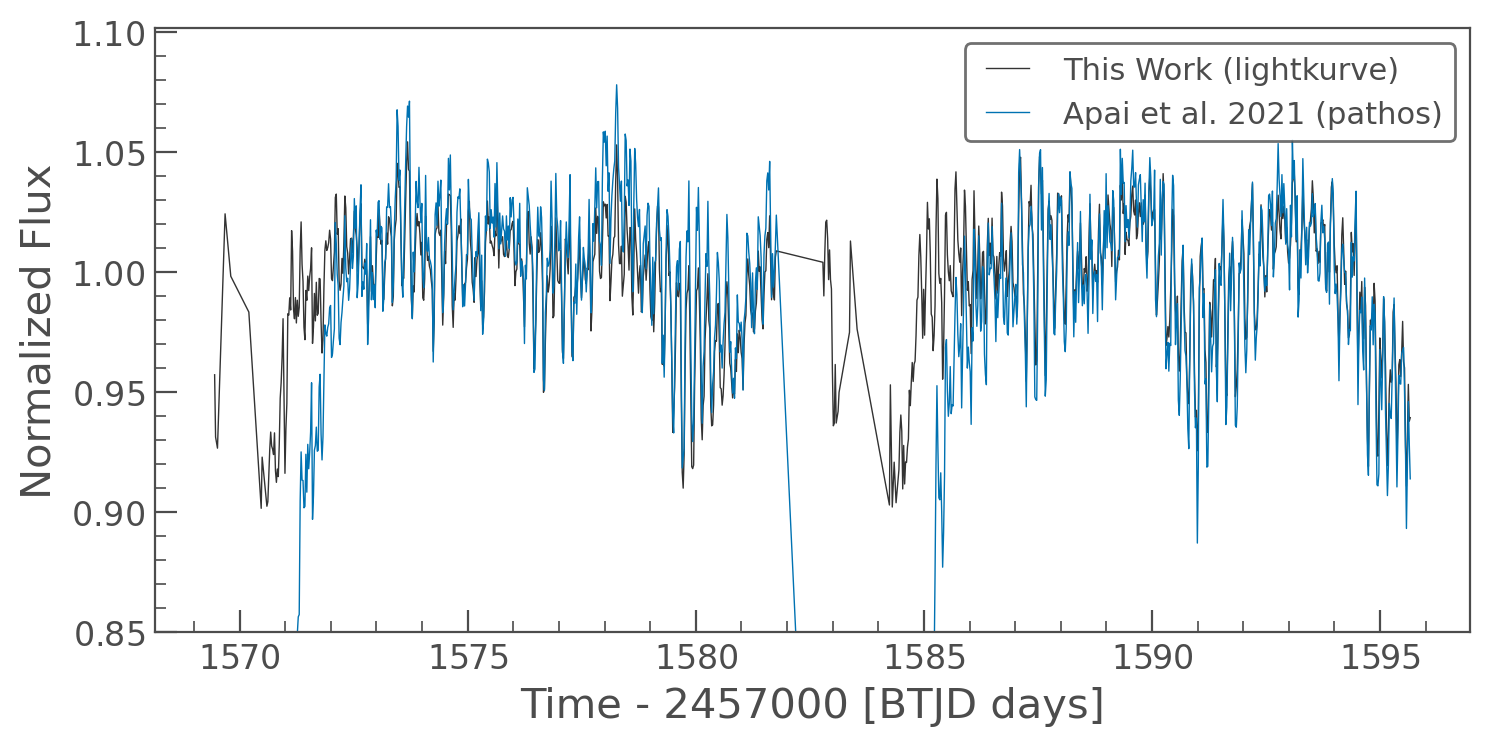

In [21]:
ax=corrected_lc.plot(label='This Work (lightkurve)')
lc_pathos.plot(ax=ax, label='Apai et al. 2021 (pathos)')
ax.set_ylim(0.85)
plt.savefig('../figures/TESS_Sector_10_lightkurve_demo.png', dpi=300, bbox_inches='tight')

Great!  We get about the same answer.  Let's save our lightcurve to a file.

In [23]:
aperture_mask.sum()

4

In [24]:
corrected_lc.to_fits(path='../data/TESS/lightkurve_custom_4pixel.fits', aperture_mask=aperture_mask)